# 1/29/21 - This notebook selects and prepares a first LinKS candidate for modeling.
# 2/10/21 - NOTE - data arrays are in units of flux calibrated to a zero point that is embedded in the "GAIN" value and must be extracted. To get in units of counts: multiply by gain and exposure time. 
## I need to use the weight maps from KiDS DR4 to create the noise map.

In [1]:
### libraries
%matplotlib inline
import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clip as clip

from pyprojroot import here

workspace_path = '/data/sknabel/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")
# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'

/data/sknabel/autolens_workspace
Working Directory has been set to `/data/sknabel/autolens_workspace`


In [2]:
# load links
links = pd.read_csv(f'{csv_path}latest/links_sample_latest.csv')
print(len(links), links.columns)

39 Index(['Unnamed: 0', 'Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'score',
       'Unnamed: 0_y', 'z1', 'sigma1', 'template1', 'z2', 'sigma2',
       'template2', 'sigma3', 'sigma4', 'R', 'prob', 'error', 'type',
       'type_number', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'z', 'zlens', 'zsource', 'sigma_lens',
       'sigma_source', 'dlens', 'dsource', 'corrected_stellar_mass', 'P1',
       'P3', 'normalized_score', 'cnn_probability', 'm_half_re', 'sigma_star',
       'theta_e_pm', 'theta_e_sis'],
      dtype='object')


In [3]:
links.sort_values(by='score', ascending=False).head()[['GAMA_ID',
                                                      'ID',
                                                       'RA',
                                                       'DEC',
                                                      'score',
                                                      'zlens',
                                                      'zsource',
                                                      'corrected_stellar_mass',
                                                      'theta_e_pm',
                                                     'theta_e_sis']]

,GAMA_ID,ID,RA,DEC,score,zlens,zsource,corrected_stellar_mass,theta_e_pm,theta_e_sis
18,323152.0,2967,130.54643,1.64325,30.0,0.353286,0.721590,NaN,NaN,NaN
17,250289.0,2730,214.36708,1.99311,28.0,0.401214,0.719616,4.664644e+11,0.917868,0.645859
19,3575500.0,1906,129.23265,-1.57512,26.0,0.232537,0.365195,3.049251e+11,1.296096,0.762649
31,3629152.0,1933,135.88864,-0.97487,26.0,0.406623,0.787118,4.270558e+11,0.896116,0.659574
11,544226.0,3212,214.42336,-0.89247,18.0,0.227044,0.649824,1.928528e+11,0.875230,0.725515


## I am selecting G3575500 (1906) with score of	26, redshifts 0.232537 and 0.365195, mass 3.049251e+11, and $\theta_E$	1.296096 and 0.762649

In [4]:
# THIS IS INCORRECT BECAUSE IT SHOULD BE FROM DR4 NOT DR3!
# It's also unnecessary because the psf is in the fits header
# pull in tile table from kids to see fwhm of psf on the tile
kids = pd.read_csv(f'{csv_path}KiDS_DR3_tile_table.csv')
kids.rename(columns={'# 1: Tile name':'tile',
                     '# 2: Right ascension (degr':'RA', # RA and DEC of center of tile
                     '# 3: Declination (degr':'DEC',
                    '# 4: Filter':'filter',
                    '# 5: Date (start of observation':'date',
                    '# 6: Average PSF FWHM (arcsec)':'avg_psf_fwhm',
                    '# 7: Average PSF ellipticity':'avg_psf_ellipticity',
                    '# 8: Limiting magnitude (5 sigma':'limiting_mag',
                     '# 9: 98% completeness (mag)':'98_complete_mag',
                     '# 10: Average effective gain': 'avg_eff_gain',
                     '# 11: Quality grade':'quality_grade'}, inplace=True)
#print(kids.columns)
#print(kids.tile)

In [5]:
# Again totally unnecessary
#find the tile
# 
lens_RA = links.iloc[19].RA
lens_DEC = links.iloc[19].DEC
r = 10.
#print(lens_RA, lens_DEC)
for i in range(len(kids)):
    tile_RA = kids.iloc[i].RA
    tile_DEC = kids.iloc[i].DEC
    R=np.sqrt((tile_RA-lens_RA)**2+(tile_DEC-lens_DEC)**2)
    if R < r:
        r = R
        tile = kids.iloc[i]
#print(f'Tile {tile.tile} is the closest at {r} arcsec away from the center.')
tile_data = kids[kids.tile==tile.tile]
#print(tile_data)

psf_r = tile_data[tile_data['filter']=='r']['avg_psf_fwhm'].values
psf_g = tile_data[tile_data['filter']=='g']['avg_psf_fwhm'].values
psf_i = tile_data[tile_data['filter']=='i']['avg_psf_fwhm'].values
#print(f'PSF: r={psf_r}, g={psf_g}, i={psf_i}')

In [6]:
# above tile is wrong!

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  101 / Number of pixels along this axis               
NAXIS2  =                  101 / Number of pixels along this axis               
EXTEND  =                    T / This file may contain FITS extensions          
OBJECT  = 'KIDS_129.0_-1.5'                                                     
ZEROPNT =                  0.0                                                  
ZPNTERR =                  0.0                                                  
CREADATE= '2017-05-05T23:15:48.000'                                             
PSF_RAD =   0.5450006723403931                                                  
INSTRUME= 'OMEGACAM'                                                            
TELESCOP= 'ESO-VLT-U0'      

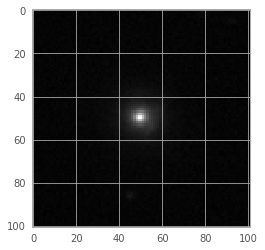

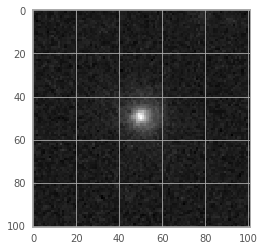

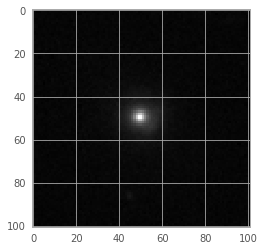

In [2]:
# Let's look at r-band image
folder = f'{fits_path}G3575500_1906/'
r = '1906_r.fits'
g = '1906_g.fits'
i = '1906_i.fits'
# get the files ready
# r
hdul = fits.open(f'{folder}{r}') # open the fits
print(repr(hdul[0].header))
#print(hdul.info())
r_image = hdul[0].data # select first HDU to be the image
hdul.close()
# g
hdul = fits.open(f'{folder}{g}') # open the fits
print(repr(hdul[0].header))
#print(hdul.info())
g_image = hdul[0].data # select first HDU to be the image
hdul.close()
# i
hdul = fits.open(f'{folder}{i}') # open the fits
#print(repr(hdul[0].header))
#print(hdul.info())
i_image = hdul[0].data # select first HDU to be the image
hdul.close()

# plot image data
plt.figure()
plt.title = (f'{hdul[0].header[6]}')
plt.imshow(r_image, cmap='gray') # show image in grayscale
plt.show()

# plot image data
plt.figure()
plt.title = (f'{hdul[0].header[6]}')
plt.imshow(g_image, cmap='gray') # show image in grayscale
plt.show()

# plot image data
plt.figure()
plt.title = (f'{hdul[0].header[6]}')
plt.imshow(i_image, cmap='gray') # show image in grayscale
plt.show()


4.4767206e-12
252501.95


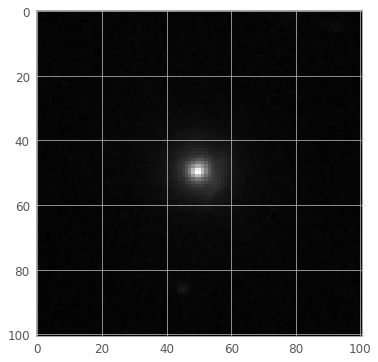

In [16]:
hdul = fits.open(f'{folder}{r}') # open the fits
# take the gain
gain = hdul[0].header['GAIN']
# take the exposure time
exp_time = 1800
r_image = hdul[0].data # select first HDU to be the image
r_image_counts = r_image*gain*exp_time # create array in counts
print(np.mean(r_image))
print(np.mean(r_image_counts))
hdul.close()

# plot image data
plt.figure()
plt.title = (f'{hdul[0].header[6]}')
plt.imshow(r_image, cmap='gray') # show image in grayscale
plt.show()

In [25]:
# function to convert fits image to counts
def count_chocula(folder, file):
    # load file
    hdul = fits.open(f'{folder}{r}') # open the fits
    # take the gain
    gain = hdul[0].header['GAIN']
    # take the filter
    gri_filter = hdul[0].header['FILT_ID']
    if gri_filter == 'OCAM_g_SDSS':
        exp_time = 900
    elif gri_filter == 'OCAM_r_SDSS':
        exp_time = 1800
    elif gri_filter == 'OCAM_i_sdss':
        exp_time = 1200
    else:
        print('Error - filter not g, r, or i')
    image = hdul[0].data # select first HDU to be the image
    image_counts = image*gain*exp_time # create array in counts
    print(np.mean(image))
    print(np.mean(image_counts))
    hdul.close()

    # plot image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image_counts, cmap='gray') # show image in grayscale
    plt.show()
    
    # write to fits file
    hdu = fits.PrimaryHDU(image_counts)
    hdu.writeto(f'{folder}{file[:-5]}_image_counts.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_image_counts.fits')
    # good vibes
    print('Hooray!')
    
    return(image_counts)

4.4767206e-12
1.424195e+22


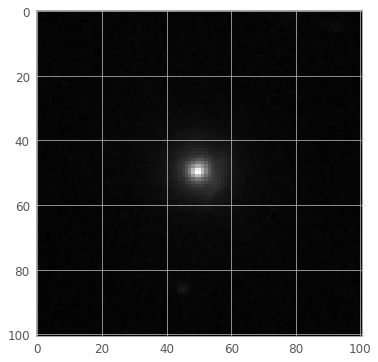

Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_image_counts.fits
Hooray!
[[-1.45546235e+21 -9.72723248e+19 -4.91090630e+21 ... -7.83192582e+21
  -2.30902354e+21  1.27013467e+22]
 [-8.51969811e+21 -1.08378344e+21  1.35257216e+22 ... -5.49027751e+21
  -5.99513201e+20  1.11813469e+22]
 [-8.84903847e+21 -1.96763323e+21  6.88010693e+21 ... -6.62906615e+21
  -2.05041981e+21  7.85804501e+21]
 ...
 [ 8.30520010e+21  4.10897734e+21 -2.10223513e+21 ... -2.24279078e+21
   8.04282039e+21  1.32911640e+22]
 [ 4.28071613e+20  2.58084491e+21  3.96454943e+21 ...  7.18772812e+21
   2.89428035e+20  1.93897528e+21]
 [-3.00150644e+21  1.40390570e+21 -1.13411976e+22 ...  1.21152347e+22
  -3.73976774e+21 -6.87631265e+21]]


In [26]:
r_image = count_chocula(folder, r)

print(r_image)

In [34]:
# resize to zoom in
#image.shape=(101,101)

def reshape_image(image, new_size):
    print(f'Resizing image to {new_size}.')
    size=image.shape[0] # 101
    center=int(image.shape[0]/2) # 50
    new_center=(new_size-1)/2
    lower = int(center-new_center) 
    upper = int(center+new_center)
    resized_image=image[lower:upper+1,lower:upper+1]
    print(f'Middle pixel at index {center}. New image created from indices {lower} to {upper} in axes 0 and 1.')
    print(f'New shape: {resized_image.shape}')
    return(resized_image)

reshape_image(r_image, 41)

Resizing image to 41.
Middle pixel at index 50. New image created from indices 30 to 70 in axes 0 and 1.
New shape: (41, 41)


array([[ 3.50336600e-12,  1.27046474e-12,  4.84754164e-12, ...,
         5.66060827e-12, -2.40089784e-12, -1.36026593e-13],
       [ 4.51255786e-12,  3.09433642e-12,  2.67316573e-12, ...,
         3.85241882e-12,  1.12602050e-12,  2.31092099e-12],
       [ 1.04962371e-12,  2.51594579e-12,  6.03811597e-13, ...,
         2.03462833e-12,  1.40982104e-12,  5.86594629e-13],
       ...,
       [ 1.76742030e-12,  6.42632865e-12,  4.71251250e-12, ...,
         7.69095725e-12,  7.33056844e-13, -1.03207576e-13],
       [ 1.81785045e-12, -4.59035587e-13,  1.57441800e-12, ...,
         4.28198752e-12,  1.39886713e-12,  3.05670181e-12],
       [ 3.09836445e-12,  2.52066987e-12,  2.50761564e-12, ...,
         1.26955293e-12,  3.14722467e-12,  5.52741533e-12]], dtype=float32)

In [8]:
# reshape and save resized image
def reshape_image_from_file(folder, file, new_size):
    # get the file ready
    hdul = fits.open(f'{folder}{file}') # open the fits
    print(f'Reshapuin with {hdul[0].header[6]}') # list object name
    print(hdul.info())
    image = hdul[0].data # select first HDU to be the image
    
    # plot image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image)#, cmap='gray') # show image in grayscale
    plt.show()
    
    image_resized=reshape_image(image, new_size)
    
    # plot resized image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image_resized)#, cmap='gray') # show image in grayscale
    plt.show()

    # write to fits file
    hdu = fits.PrimaryHDU(image_resized)
    hdu.writeto(f'{folder}{file[:-5]}_image_resized.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_image_resized.fits')
    # good vibes
    print('Hooray!')

Gettin noisey with KIDS_129.0_-1.5
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


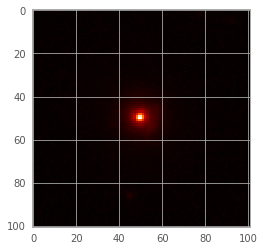

Resizing image to half size.
Middle pixel at index 25. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)


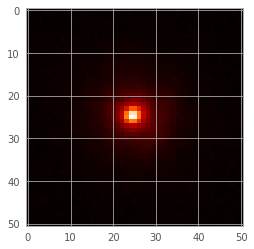

Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_image_resized.fits
Hooray!
Gettin noisey with KIDS_129.0_-1.5
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_g.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


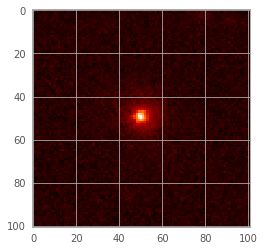

Resizing image to half size.
Middle pixel at index 25. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)


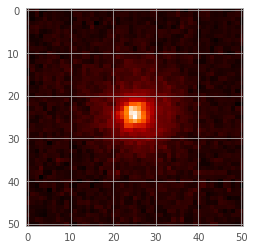

Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_g_image_resized.fits
Hooray!
Gettin noisey with KIDS_129.0_-1.5
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


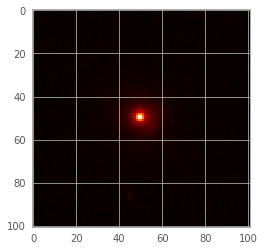

Resizing image to half size.
Middle pixel at index 25. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)


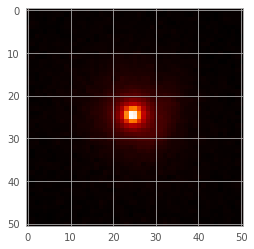

Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i_image_resized.fits
Hooray!


In [9]:
reshape_image_from_file(folder, r, 25)
reshape_image_from_file(folder, g, 25)
reshape_image_from_file(folder, i, 25)


In [10]:
def get_noisey_from_file(folder, file, new_size): # insert fits file path (f'{fits_image_path}links/G262874_26/G262874_26_r.fits')
    
    # get the file ready
    hdul = fits.open(f'{folder}{file}') # open the fits
    print(f'Gettin noisey with {hdul[0].header[6]}') # list object name
    print(hdul.info())
    image = hdul[0].data # select first HDU to be the image
    
    # plot image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image)#, cmap='gray') # show image in grayscale
    plt.show()
    #
    plt.figure()
    plt.title = (f'{hdul[0].header[6]} signal')
    plt.hist(np.ravel(image),bins=100,log=True) # plot signal in histogram
    plt.show()
    print(f'Mean {np.mean(image)}, Median {np.median(image)}')
    
    # clip to 3sigma around median
    print('Clipping to 3-sigma about median value')
    clipped_image=clip(image, cenfunc='median')
    plt.figure()
    plt.title=(f'{hdul[0].header[6]} noise')
    plt.hist(np.ravel(clipped_image),bins=100,log=True) # plot signal in histogram
    plt.show()
    
    # generate Gaussian noise about mean and std
    mean = clipped_image.mean()
    std = clipped_image.std()
    noise_map = np.random.normal(loc=mean,
                                scale=std,
                                size= image.shape
                                )
    
    # plot noise map
    plt.figure() # show histogram of signal values
    plt.hist(np.ravel(noise_map))
    plt.show()
    plt.figure() # show noise map image
    plt.title=(f'Noise Map for {hdul[0].header[6]}')
    plt.imshow(noise_map, cmap='gray')
    
    # write to fits file
    hdu = fits.PrimaryHDU(noise_map)
    hdu.writeto(f'{folder}{file[:-5]}_noisemap.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_noisemap.fits')
    
    # resize noise map
    noise_map_resized = reshape_image(noise_map, new_size)
    print(f'New noise_map shape: {noise_map_resized.shape}')
    plt.figure() # show noise map image
    plt.title=(f'Noise Map for {hdul[0].header[6]}')
    plt.imshow(noise_map_resized, cmap='gray')
    
    # write to fits file
    hdu = fits.PrimaryHDU(noise_map_resized)
    hdu.writeto(f'{folder}{file[:-5]}_noisemap_resized.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_noisemap_resized.fits')
    # good vibes
    print('Congratulations! You simulated random noise! Eat a cookie.')
    
    
#get_noisey(f'{fits_image_path}links/G262874_26/G262874_26_r.fits') # it works!

Gettin noisey with KIDS_129.0_-1.5
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


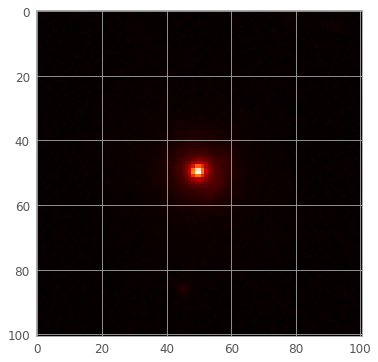

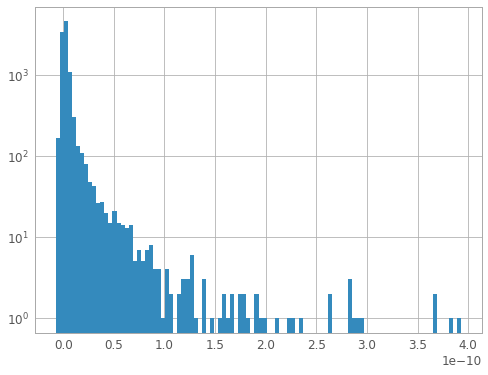

Mean 4.476720643492582e-12, Median 1.5364653993543698e-12
Clipping to 3-sigma about median value


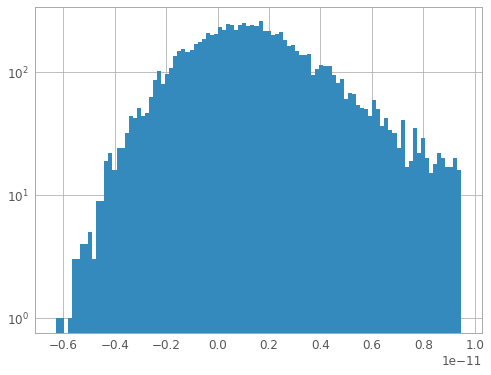

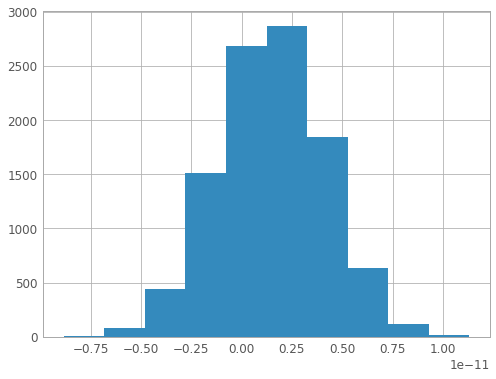

Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_noisemap.fits
Resizing image to half size.
Middle pixel at index 25. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)
New noise_map shape: (51, 51)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_noisemap_resized.fits
Congratulations! You simulated random noise! Eat a cookie.
Gettin noisey with KIDS_129.0_-1.5
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_g.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


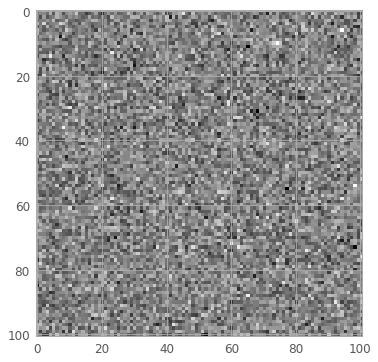

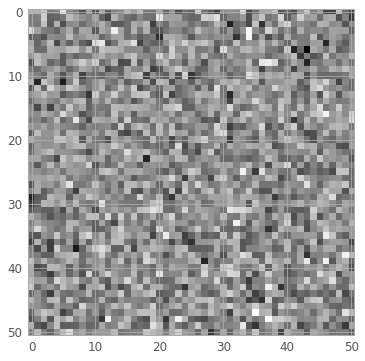

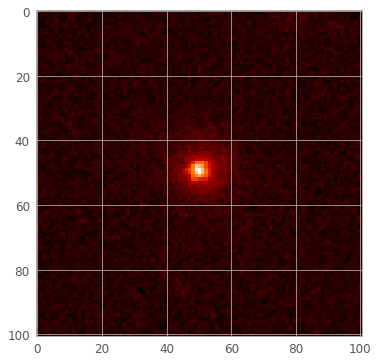

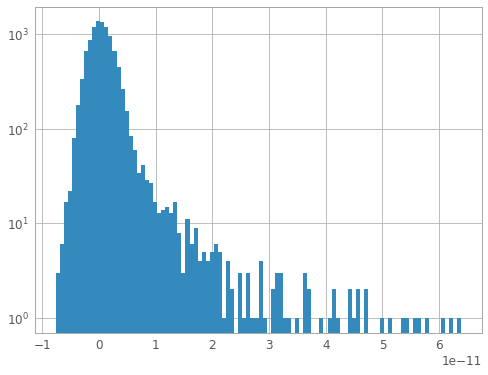

Mean 9.152725235703207e-13, Median 4.459449031834345e-13
Clipping to 3-sigma about median value


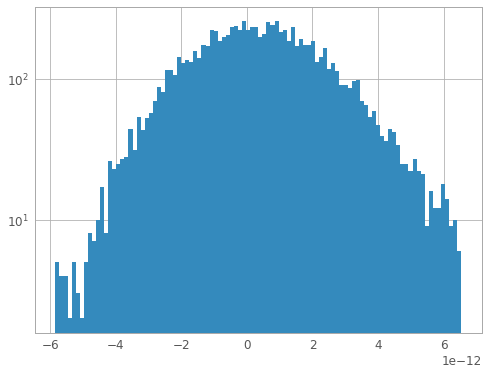

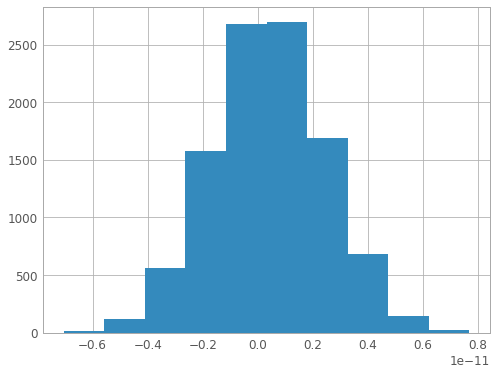

Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_g_noisemap.fits
Resizing image to half size.
Middle pixel at index 25. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)
New noise_map shape: (51, 51)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_g_noisemap_resized.fits
Congratulations! You simulated random noise! Eat a cookie.
Gettin noisey with KIDS_129.0_-1.5
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


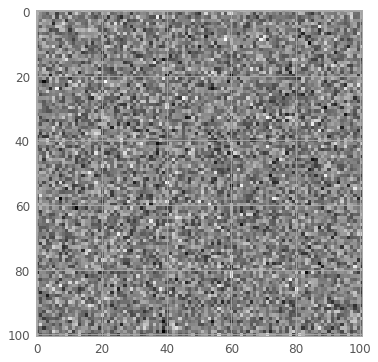

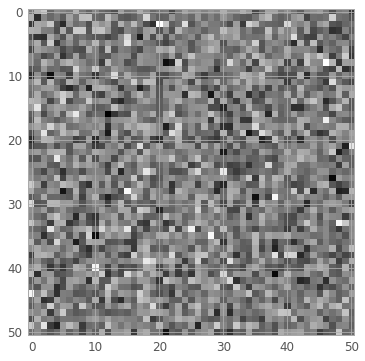

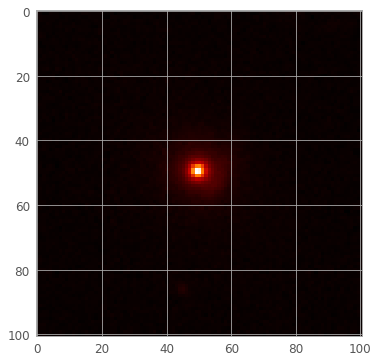

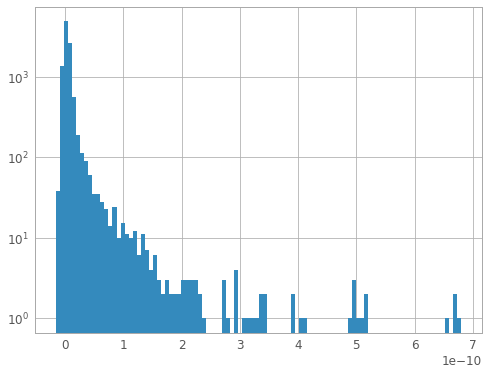

Mean 7.821917592798489e-12, Median 2.898613640778258e-12
Clipping to 3-sigma about median value


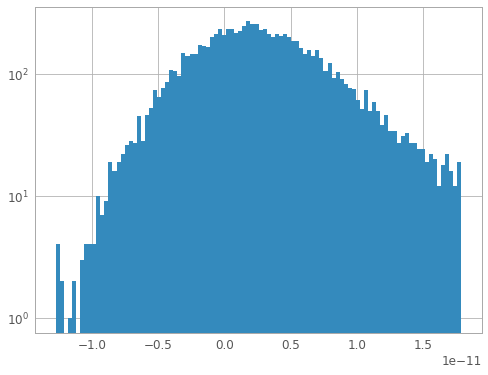

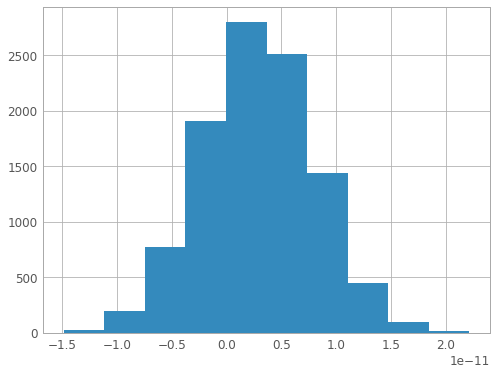

Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i_noisemap.fits
Resizing image to half size.
Middle pixel at index 25. New image created from indices 25 to 75 in axes 0 and 1.
New shape: (51, 51)
New noise_map shape: (51, 51)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i_noisemap_resized.fits
Congratulations! You simulated random noise! Eat a cookie.


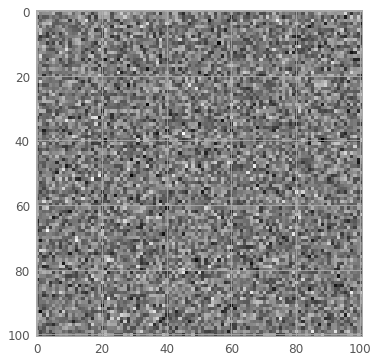

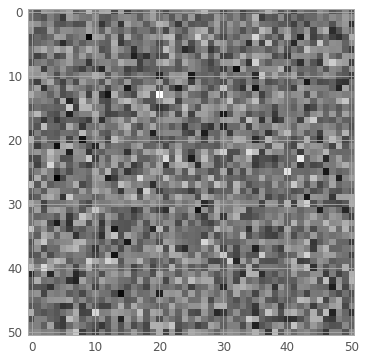

In [28]:
get_noisey_from_file(folder, r, 25)
get_noisey_from_file(folder, g, 25)
get_noisey_from_file(folder, i, 25)

## Need to determine pixel scale. I don't believe I've been able to find it in the data from the fits file. Maybe I'm just not looking closely enough.
## Petrillo-18 says it's 101x101 pixels (20x20 arcsec)
## I take that to mean that the pixel scale is 20/101 or 0.198 arcsec per pixel.
# KiDS DR4 says pixel scale is 0.2
## Average PSF is 0.65... How many pixels is that? that's 2$\sigma$ of the Gaussian? Divide by 2? That gives us sigma_psf?

(41, 41)

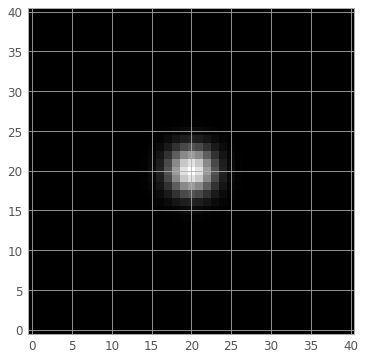

In [29]:
# from astropy tutorial
size = 20  # on each side from the center
sigma_psf = 2.0
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')
psf.shape

In [30]:
avg_psf = 0.65 # arcsec
avg_psf_pxl = 0.65/0.198 # pixels
sigma_psf = avg_psf_pxl/2 # = 1.64
sigma_psf

1.6414141414141414

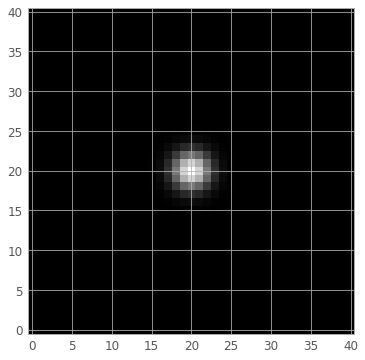

In [31]:
# let's try to make this work...
size = 20 # gives a grid of 41 (20 on either side of the center)
y, x = np.mgrid[-size:size+1, -size:size+1]
psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
psf /= np.sum(psf)
plt.imshow(psf, origin='lower', cmap='gray')

In [35]:
# write a function for psf determination (r band is 0.65 arcsec and 0.198 pixelscale)
def point_to_the_spread(folder, file, psf, pixel_scale, new_size):
    # get the file ready
    hdul = fits.open(f'{folder}{file}') # open the fits
    print(f'Point the way to {hdul[0].header[6]}!') # list object name
    print(hdul.info())
    image = hdul[0].data # select first HDU to be the image
    
    # plot image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image)#, cmap='gray') # show image in grayscale
    plt.show()
    
    # define psf values
    avg_psf = psf # arcsec
    avg_psf_pxl = avg_psf/pixel_scale # pixels
    sigma_psf = avg_psf_pxl/2 # = 1.64
    size = int(np.around(image.shape[0]/2)) # gives a grid of 101 (50 on either side of the center)
    
    # set psf for 101, 101 image
    y, x = np.mgrid[-size:size+1, -size:size+1]
    psf = np.exp(-(x**2 + y**2)/(2.0*sigma_psf**2))
    psf /= np.sum(psf)
    plt.imshow(psf, origin='lower', cmap='gray')
    print(psf.shape)
    
    # write to fits file
    hdu = fits.PrimaryHDU(psf)
    hdu.writeto(f'{folder}{file[:-5]}_psf.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_psf.fits')
    
    # resize psf
    psf_resized = reshape_image(psf, new_size) # cut to 21x21
    print(f'New noise_map shape: {psf_resized.shape}')
    plt.figure() # show psf image
    plt.title=(f'psf for {hdul[0].header[6]}')
    plt.imshow(psf_resized, cmap='gray')
    
    # write to fits file
    hdu = fits.PrimaryHDU(psf_resized)
    hdu.writeto(f'{folder}{file[:-5]}_psf_resized.fits', overwrite=True)
    print(f'Image sent to {folder}{file[:-5]}_psf_resized.fits')
    # good vibes
    print('This has been fun, right? Very fun! :)')

Point the way to KIDS_129.0_-1.5!
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


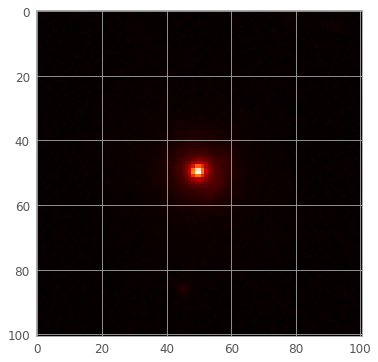

(101, 101)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_psf.fits
Resizing image to half size.
Middle pixel at index 10. New image created from indices 40 to 60 in axes 0 and 1.
New shape: (21, 21)
New noise_map shape: (21, 21)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_psf_resized.fits
This has been fun, right? Very fun! :)
Point the way to KIDS_129.0_-1.5!
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_g.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


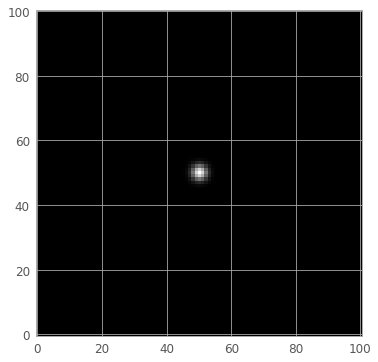

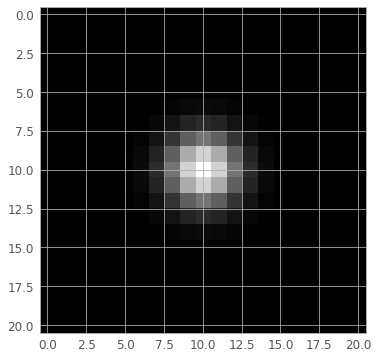

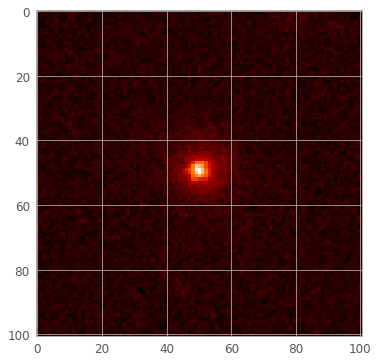

(101, 101)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_g_psf.fits
Resizing image to half size.
Middle pixel at index 10. New image created from indices 40 to 60 in axes 0 and 1.
New shape: (21, 21)
New noise_map shape: (21, 21)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_g_psf_resized.fits
This has been fun, right? Very fun! :)
Point the way to KIDS_129.0_-1.5!
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


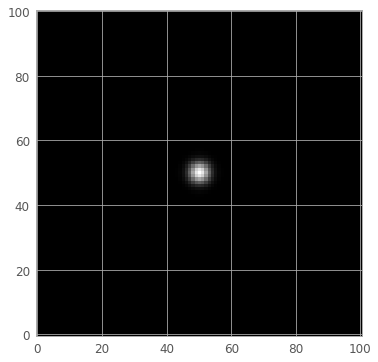

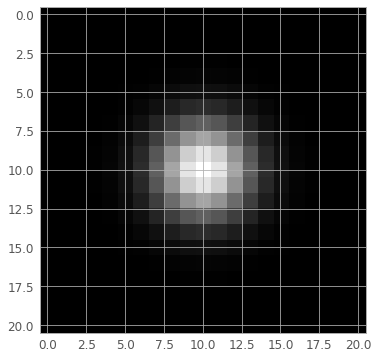

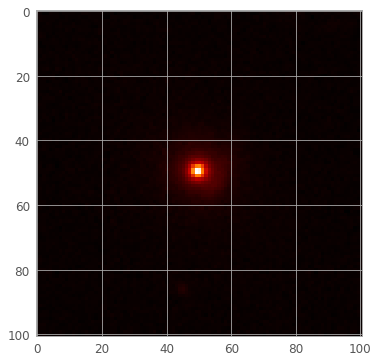

(101, 101)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i_psf.fits
Resizing image to half size.
Middle pixel at index 10. New image created from indices 40 to 60 in axes 0 and 1.
New shape: (21, 21)
New noise_map shape: (21, 21)
Image sent to /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_i_psf_resized.fits
This has been fun, right? Very fun! :)


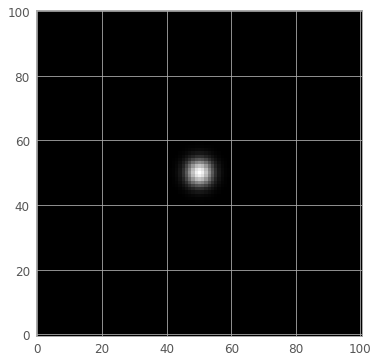

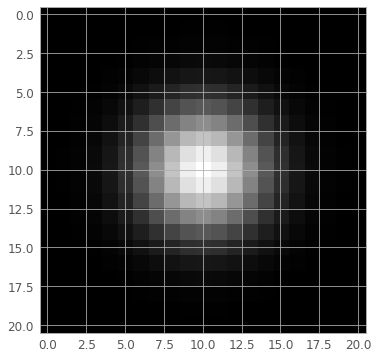

In [33]:
point_to_the_spread(folder, r, psf=psf_r, pixel_scale=0.198, new_size=10)
point_to_the_spread(folder, g, psf=psf_g, pixel_scale=0.198, new_size=10)
point_to_the_spread(folder, i, psf=psf_i, pixel_scale=0.198, new_size=10)

## Woo! I think I got it :)

## 2/5/21 - It appears the noise map has been completely wrong... I'm going to try a really stupid thing where I just take the square root of each pixel (because that's totally not the easiest thing that could every be programmed into the autolens library?)...

In [27]:
def stupid_noise (folder, file):
    # get the file ready
    hdul = fits.open(f'{folder}{file}') # open the fits
    print(f'Gettin noisey with {hdul[0].header[6]}') # list object name
    print(hdul.info())
    image = hdul[0].data # select first HDU to be the image
    
    # plot image data
    plt.figure()
    plt.title = (f'{hdul[0].header[6]}')
    plt.imshow(image)#, cmap='gray') # show image in grayscale
    plt.show()
    
    # generate noise map by taking square root of each pixel
    noise_map = np.sqrt(image)
    
    # plot noise map
    plt.figure() # show histogram of signal values
    plt.hist(np.ravel(noise_map))
    plt.show()
    plt.figure() # show noise map image
    plt.title=(f'Noise Map for {hdul[0].header[6]}')
    plt.imshow(noise_map, cmap='gray')
    
    print('Congratulations! You simulated random noise! Eat a cookie.')

Gettin noisey with KIDS_129.0_-1.5
Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (101, 101)   float32   
None


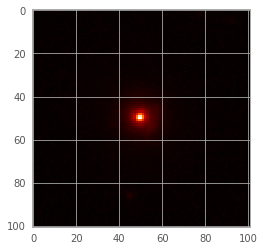

/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


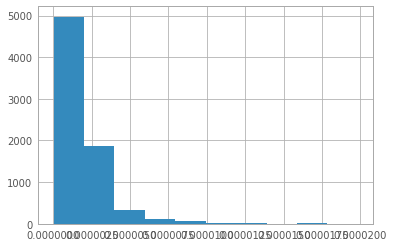

Congratulations! You simulated random noise! Eat a cookie.


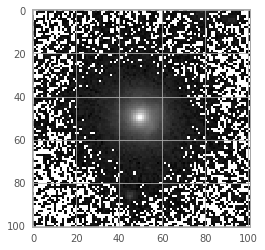

In [28]:
stupid_noise(folder, r)

# This absolutely did not work. Lol

# 2/10/21 - Noise map from weight map... Here we go.

In [1]:
# get the tile centered at closest to object at 129.23265, -1.57512
# tiles are a square degree, meaning that each side is 3600 arcsec
# 0th pixel is then RA : 131.0+0.5=131.5 , DEC : -0.5 + 0.5 = 0.0
# pixel scale is 0.2 arcsec/pixel
# this means the tile is 3600 arcsec/(0.2 arcsec/pixel) = 18000 pixels on each side

In [2]:
3600/0.2

18000.0

In [10]:
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
hdul = fits.open(f'{folder}{r}') # open the fits

wcs = WCS(hdul[0].header)
wcs.crpix=[50,50]
print(wcs)

image = hdul[0].data # select first HDU to be the image
hdul.close()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 129.0  -1.489010989  
CRPIX : 4237.0  1601.0  
CD1_1 CD1_2  : -5.555555638e-05  0.0  
CD2_1 CD2_2  : 0.0  5.555555638e-05  
NAXIS : 101  101


In [11]:
wcs.world_axis_physical_types 

['pos.eq.ra', 'pos.eq.dec']

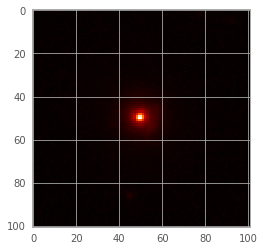

In [12]:
plt.imshow(image)

In [25]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.nddata import Cutout2D

coord=SkyCoord(ra=wcs.wcs.crval[0], dec=wcs.wcs.crval[1], unit='deg', frame='icrs') # international celestial reference frame
position = wcs.world_to_array_index(coord)
print(wcs.wcs.crval)
print(position)
print(np.unravel_index(position[0], (101, 101)))
size = u.Quantity(5, u.arcsec)

cutout = Cutout2D(data=image, position=position, size=size, wcs=wcs, mode='trim')
plt.imshow(cutout.data, origin='lower')   


[129.          -1.48901099]
(1600, 4236)
(15, 85)


NoOverlapError: Arrays do not overlap.

In [22]:
# okay let's try this with the weight map coadd

In [46]:
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
hdul = fits.open(f'{folder}1906_r_weight.fits', memmap=False)#, lazy_load_hdus=True, mode='denywrite') # open the fits
#print(repr(hdul[0].header))
wcs = WCS(hdul[0].header)
#print(hdul[0].data)
fits.info(f'{folder}1906_r_weight.fits')
#print(wcs)

image = hdul[0].data # select first HDU to be the image
#plt.imshow(image)
hdul.close()

Filename: /data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_weight.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (18687, 20024)   float32   


ValueError: cannot reshape array of size 1046416 into shape (20024,18687)

In [13]:
# try using fitsio
import fitsio
from fitsio import FITS,FITSHDR

In [14]:
fitsio.read(f'{folder}1906_r_weight.fits')

OSError: FITSIO status = 108: error reading from FITS file
Error reading data buffer from file:
/data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_weight.fits
Error reading elements 1 thru 374188488 from image (ffgcle).


In [11]:
hdul = FITS(f'{folder}1906_r_weight.fits')
image = hdul[0].read()
header = image.read_header()
info = image.read_info()
print(header, info, image)

OSError: FITSIO status = 108: error reading from FITS file
Error reading data buffer from file:
/data/sknabel/autoz_lens_model/files/fits/G3575500_1906/1906_r_weight.fits
Error reading elements 1 thru 374188488 from image (ffgcle).


In [12]:
help(fitsio)

Help on package fitsio:

NAME
    fitsio

DESCRIPTION
    A python library to read and write data to FITS files using cfitsio.
    See the docs at https://github.com/esheldon/fitsio for example
    usage.

PACKAGE CONTENTS
    _fitsio_wrap
    fitslib
    test
    util

DATA
    ASCII_TBL = 1
    BINARY_TBL = 2
    IMAGE_HDU = 0
    READONLY = 0
    READWRITE = 1

VERSION
    0.9.12

FILE
    /soft/anaconda3/lib/python3.7/site-packages/fitsio/__init__.py


